In [2]:
import GMMfunction as GMM
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import os
import subprocess # inkspace
from scipy.linalg import toeplitz
np.random.seed(30)
# import seaborn as sns
# sns.set_style('white')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmu-serif",
    "mathtext.fontset": "cm",
    "font.size": 18
})

# MACos only
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"


In [3]:
import subprocess
print(subprocess.getoutput("which latex"))
print(subprocess.getoutput("latex --version"))

/Library/TeX/texbin/latex
pdfTeX 3.141592653-2.6-1.40.26 (TeX Live 2024)
kpathsea version 6.4.0
Copyright 2024 Han The Thanh (pdfTeX) et al.
There is NO warranty.  Redistribution of this software is
covered by the terms of both the pdfTeX copyright and
the Lesser GNU General Public License.
For more information about these matters, see the file
named COPYING and the pdfTeX source.
Primary author of pdfTeX: Han The Thanh (pdfTeX) et al.
Compiled with libpng 1.6.43; using libpng 1.6.43
Compiled with zlib 1.3.1; using zlib 1.3.1
Compiled with xpdf version 4.04


In [4]:
M, DX, DY, N, noise_level = (2, 3, 3, 10000, 2) # number of individual gaussians, dimension of the data, number of samples
mus = GMM.generate_mu_list(M, DX)
sigmas = GMM.generate_sigma_list(M, DX)
# mus = [np.array([1, 2]), np.array([8, 10])]
# sigmas = [np.array([[1, 0], [0, 2]]), np.array([[2, 1], [1, 1]])]
x = GMM.sample_multivariate_gaussian_mixture(mus, sigmas, N).T

A = np.random.randn(DY, DX)
Nsigma, n = GMM.generate_noise(noise_level, DY, N)

y = A @ x + n

train_samples_x = x[:, :int(x.shape[-1] * 0.8)]
test_samples_x  = x[:, int(x.shape[-1] * 0.8):]
train_samples_y = y[:, :int(y.shape[-1] * 0.8)]
test_samples_y  = y[:, int(y.shape[-1] * 0.8):]

Text(0.5, 1.0, '$p(x)$ vs $p(x|y)$')

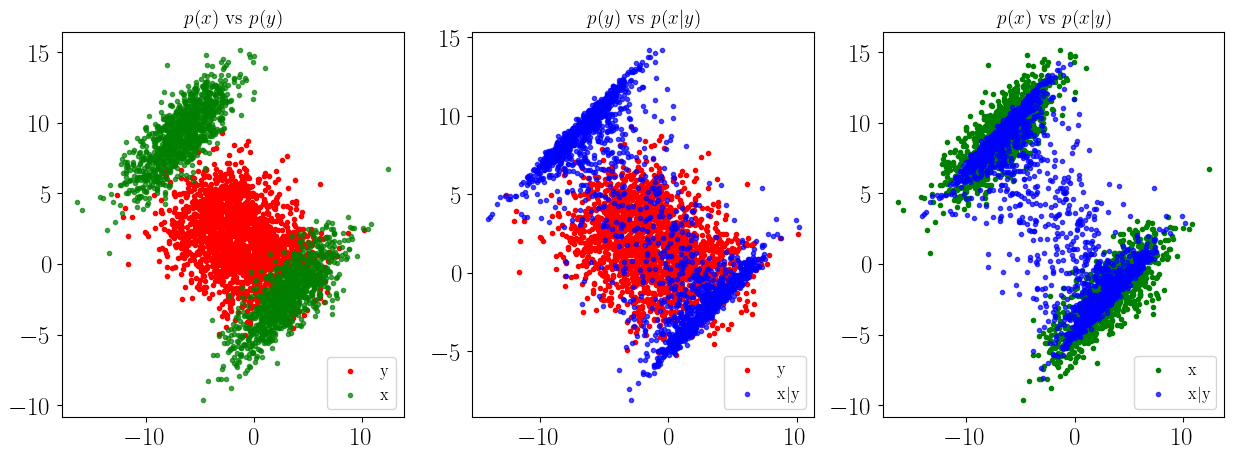

In [5]:

%matplotlib inline
mu1_real_res = GMM.mu1_real(test_samples_y, A, mus, sigmas, Nsigma)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='red', alpha=1, label='y')
# sns.scatterplot(test_samples_y, marker='.', color='red', alpha=1, label='y')
plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='green', alpha=0.7, label='x')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(x)$ vs $p(y)$', fontsize=14)

plt.subplot(1, 3, 2)
plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='red', alpha=1, label='y')
plt.scatter(mu1_real_res[0], mu1_real_res[1], marker='.', color='blue', alpha=0.7, label='x$|$y')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(y)$ vs $p(x|y)$', fontsize=14)

plt.subplot(1, 3, 3)
plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='green', alpha=1, label='x')
plt.scatter(mu1_real_res[0], mu1_real_res[1], marker='.', color='blue', alpha=0.7, label='x$|$y')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(x)$ vs $p(x|y)$', fontsize=14)

In [6]:
x_1 = GMM.sample_multivariate_gaussian_mixture(mus, sigmas, 1).T
mmse = A @ x_1 + GMM.generate_noise(noise_level, DX, 1)[1]
bmmse = np.concatenate([mmse] * 2, axis=1)

In [7]:
n_ev = 2 # number of eigenvectors
x_1 = GMM.sample_multivariate_gaussian_mixture(mus, sigmas, 1).T
y_1 = A @ x_1 + GMM.generate_noise(noise_level, DY, 1)[1]

first_moments, second_moments, eigvecs, eigvals, mmse = GMM.moment_calculation(y_1, A, mus, sigmas, Nsigma, n_ev)

plt.figure(figsize=(6,5))

[XX, YY] = np.meshgrid(np.linspace(-10,10,100), np.linspace(-10,10,100))
xs = np.stack([XX.ravel(), YY.ravel()])
print(xs.shape)
c = plt.imshow(GMM.px_pdf_real(xs, mus, sigmas).reshape(XX.shape), cmap='Blues', origin='lower', extent=[-20, 20, -20, 20], interpolation='bilinear')

angle = np.arctan2(eigvecs[1,0], eigvecs[0,0]) * 180 / np.pi
ellipse = patches.Ellipse((mmse[0,0], mmse[1,0]), 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=angle,
                          fill=False, alpha=0.7, edgecolor='#053061', label='$\sqrt{\lambda}$')
plt.gca().add_artist(ellipse)

threesig_ellipse = patches.Ellipse((mmse[0,0], mmse[1,0]), 6 * np.sqrt(eigvals[0]), 6 * np.sqrt(eigvals[1]), angle=angle,
                          fill=False, alpha=0.7, edgecolor='#053061', linestyle='--', label='$3\sqrt{\lambda}$')
plt.gca().add_artist(threesig_ellipse)

eigvecs /= np.linalg.norm(eigvecs, axis=0, keepdims=True)
eigvals = np.abs(eigvals)

plt.arrow(mmse[0,0], mmse[1,0], eigvecs[0,0] * 3 * np.sqrt(eigvals[0]), eigvecs[1,0] * 3 * np.sqrt(eigvals[0]), head_length=0, color='#d6604d', linewidth=2, label='$v_1$')
plt.arrow(mmse[0,0], mmse[1,0], -eigvecs[0,0] * 3 * np.sqrt(eigvals[0]), -eigvecs[1,0] * 3 * np.sqrt(eigvals[0]), head_length=0, color='#d6604d', linewidth=2)
if n_ev > 1:
    plt.arrow(mmse[0,0], mmse[1,0], eigvecs[0,1] * 3 * np.sqrt(eigvals[1]), eigvecs[1,1] * 3 * np.sqrt(eigvals[1]), head_length=0, color='#f7b068', linewidth=2, label='$v_2$')
    plt.arrow(mmse[0,0], mmse[1,0], -eigvecs[0,1] * 3 * np.sqrt(eigvals[1]), -eigvecs[1,1] * 3 * np.sqrt(eigvals[1]), head_length=0, color='#f7b068', linewidth=2)
plt.scatter(y_1[0], y_1[1], marker='o', color='red', label='$y$', s=70)
plt.scatter(mmse[0], mmse[1], marker='o', color='black', label='$\mu_1(y)$', s=70)

y_up = (mmse + 3 * np.sqrt(eigvals) * eigvecs)[:,0]
y_down = (mmse - 3 * np.sqrt(eigvals) * eigvecs)[:, 0]

plt.colorbar(c, ax=plt.gca(), label="$p_x$", fraction=0.046, pad=0.04)

plt.legend(loc='lower right', labelspacing=0.3)
plt.tight_layout()
ylimmin, ylimmax = plt.gca().get_ylim()
xlimmin, xlimmax = plt.gca().get_xlim()
os.makedirs('Figures', exist_ok=True)
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.pdf'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.svg'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.eps'), dpi=500, bbox_inches='tight')
subprocess.call('inkscape Figures/GMM_Example_theoretical.svg --export-type="emf"',shell=True)

plt.show()

(3, 3)
(2, 10000)


/Users/sx/Desktop/GaussianDenoisingPosterior/GMMexample/GMMfunction.py:181: RuntimeWarning: invalid value encountered in divide
  eigvecs = Ab / norm_of_Ab


ValueError: operands could not be broadcast together with shapes (2,10000) (3,1) 

<Figure size 600x500 with 0 Axes>